In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import io
import re

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from torch.distributions import Categorical

from torchtext.datasets import WikiText2, EnWik9, AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
from torch.hub import load_state_dict_from_url
from torchtext.data.functional import sentencepiece_tokenizer, load_sp_model

from tqdm import trange, tqdm

/home/kennykguo/anaconda3/envs/deep-learning/lib/python3.8/site-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/kennykguo/anaconda3/envs/deep-learning/lib/python3.8/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/kennykguo/anaconda3/envs/deep-learning/lib/python3.8/site-packages/torchte

In [2]:
# Define hyperparameters
# Step size for parameter updates
learning_rate = 1e-4

# Number of training epochs
nepochs = 20

# Number of samples processed together
batch_size = 32

# Maximum sequence length
max_len = 128

# Root directory of the dataset
data_set_root = "../../data/news_data"

In [3]:
# AGNews dataset class definition
class AGNews(Dataset):
    def __init__(self, test_train="train"):
        # Read the AG News dataset CSV file based on the test_train parameter (train or test)
        self.df = pd.read_csv(os.path.join(data_set_root, test_train + ".csv"),
                              names=["Class", "Title", "Content"])
        
        # Fill missing values with empty string
        self.df.fillna('', inplace=True)
        
        # Combine Title and Content columns into a single Article column
        self.df['Article'] = self.df['Title'] + " : " + self.df['Content']
        
        # Drop Title and Content columns as they are no longer needed
        self.df.drop(['Title', 'Content'], axis=1, inplace=True)
        
        # Replace special characters with whitespace in the Article column
        self.df['Article'] = self.df['Article'].str.replace(r'\\n|\\|\\r|\\r\\n|\n|"', ' ', regex=True)

    # Method to get a single item from the dataset
    def __getitem__(self, index):
        # Get the text of the article at the given index, converted to lowercase
        text = self.df.loc[index]["Article"].lower()

        return text

    # Method to get the length of the dataset
    def __len__(self):
        # Return the total number of articles in the dataset
        return len(self.df)

In [4]:
dataset_train = AGNews(test_train="train")
dataset_test = AGNews(test_train="test")
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [5]:
sp_model = load_sp_model("../../data/news_data/spm_ag_news.model")

# Create a tokenizer using the loaded model
tokenizer = sentencepiece_tokenizer(sp_model)

# Iterate over tokens generated by the tokenizer
for token in tokenizer(["i am creating"]):
    print(token)

['▁i', '▁am', '▁creat', 'ing']


In [11]:
# Define a function to yield tokens from a file
def yield_tokens(file_path):
    # Open the file in UTF-8 encoding
    with io.open(file_path, encoding='utf-8') as f:
        # Iterate over each line in the file
        for line in f:
            # Yield the token split by tab character
            yield [line.split("\t")[0]]

# Build a vocabulary from the tokens yielded by the yield_tokens function
    # <pad> is a padding token that is added to the end of a sentence to ensure the length of all sequences in a batch is the same
    # <sos> signals the "Start-Of-Sentence" aka the start of the sequence
    # <eos> signal the "End-Of-Sentence" aka the end of the sequence
    # <unk> "unknown" token is used if a token is not contained in the vocab
# From torchtext library (build_vocab_from_iterator)
# Builds a generator object, that is treated like an iterator
# Define special tokens with special_first=True to place them at the beginning of the vocabulary

vocab = build_vocab_from_iterator(
    yield_tokens("../../data/news_data/spm_ag_news.vocab"),
    specials=['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)

# Set default index for out-of-vocabulary tokens
vocab.set_default_index(vocab['<unk>'])

In [12]:
class TokenDrop(nn.Module):
    """ For a batch of tokens indices, randomly replace a non-specical token with <pad>.
    prob (float): probability of dropping a token
    pad_token (int): index for the <pad> token
    num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        # Randomly sample a bernoulli distribution with p = prob
        # Create a mask where 1 means we will replace that token
        # Discrete probability distribution
        # Here we want to treat the ones as the indexes to drop
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        # Only replace if the token is not a special token
        # Ones or zeros. If cannot drop, 0, if can drop, 1
        can_drop = (sample >= self.num_special).long()
        # Multiply together to get the corresponding tokens to be dropped and not dropped
        # Here, 1 represents drop, 0 represents do not drop
        mask = mask * can_drop

        # Make a mask of pad_token to use for replacing dropped indices with the pad_token
        replace_with = (self.pad_token * torch.ones_like(sample)).long()
        """ Sample is the original sample
        The mask indicates what tokens can be replaced (0 to not be replaced, 1 to be replaced)
        Replace_with is a list of of the pad_token tokens
        Here, (1-mask) creates the complement mask. (now, 0 indicates drop, 1 indicates to not drop)
        1-1 = 0, 1-0 = 0
        Multiplying by sample, retains the original tokens that are not to be kept, and applies the mask on the sample
        Here, mask * replace_with does elementwise multiplication and adds the corresponding pad_token to the tokens replaced
        """
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

In [14]:
# Define a transformation pipeline for training data
train_transform = T.Sequential(
    # Tokenize sentences using pre-existing SentencePiece tokenizer model
    T.SentencePieceTokenizer("../../data/news_data/spm_ag_news.model"),
    # Convert tokens to indices based on given vocabulary
    T.VocabTransform(vocab=vocab),
    # Add <sos> token at the beginning of each sentence (index 1 in vocabulary)
    T.AddToken(1, begin=True),
    # Crop the sentence if it is longer than the max length
    T.Truncate(max_seq_len=max_len),
    # Add <eos> token at the end of each sentence (index 2 in vocabulary)
    T.AddToken(2, begin=False),
    # Convert the list of lists to a tensor and pad sentences with the <pad> token if shorter than max length
    T.ToTensor(padding_value=0)
)

# Define a transformation pipeline for generation (without truncation)
gen_transform = T.Sequential(
    # Tokenize sentences using pre-existing SentencePiece tokenizer model
    T.SentencePieceTokenizer("../../data/news_data/spm_ag_news.model"),
    # Convert tokens to indices based on given vocabulary
    T.VocabTransform(vocab=vocab),
    # Add <sos> token at the beginning of each sentence (index 1 in vocabulary)
    T.AddToken(1, begin=True),
    # Convert the list of lists to a tensor and pad sentences with the <pad> token if shorter than max length
    T.ToTensor(padding_value=0)
)

In [15]:
text = next(iter(data_loader_train))
index = 0
input_tokens = train_transform(text)
print("SENTENCE")
print(text[index])
print()
print("TOKENS")
print(vocab.lookup_tokens(input_tokens[index].numpy()))

SENTENCE
un agency agrees to police iranian enrichment freeze as us voices &lt;b&gt;...&lt;/b&gt; : vienna, austria - the un nuclear agency agreed on ways to police irans suspension of some nuclear programs, but a us official said washington might still try to take the case to the security council.

TOKENS
['<sos>', '▁un', '▁agency', '▁agree', 's', '▁to', '▁police', '▁iranian', '▁enrichment', '▁freeze', '▁as', '▁us', '▁voices', '▁&', 'lt', '<unk>', 'b', '&', 'gt', '<unk>', '...', '&', 'lt', '<unk>', '/', 'b', '&', 'gt', '<unk>', '▁:', '▁vienna', '<unk>', '▁austria', '▁-', '▁the', '▁un', '▁nuclear', '▁agency', '▁agreed', '▁on', '▁ways', '▁to', '▁police', '▁iran', 's', '▁suspension', '▁of', '▁some', '▁nuclear', '▁programs', '<unk>', '▁but', '▁a', '▁us', '▁official', '▁said', '▁washington', '▁might', '▁still', '▁try', '▁to', '▁take', '▁the', '▁case', '▁to', '▁the', '▁security', '▁council', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad

In [16]:
print("TOKENS BACK TO SENTENCE")

pred_text = "".join(vocab.lookup_tokens(input_tokens[index].numpy()))
pred_text.replace("▁", " ")

TOKENS BACK TO SENTENCE


'<sos> un agency agrees to police iranian enrichment freeze as us voices &lt<unk>b&gt<unk>...&lt<unk>/b&gt<unk> : vienna<unk> austria - the un nuclear agency agreed on ways to police irans suspension of some nuclear programs<unk> but a us official said washington might still try to take the case to the security council.<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

In [17]:
class LSTM(nn.Module):
    def __init__(self, num_emb, num_layers=1, emb_size=128, hidden_size=128):
        super(LSTM, self).__init__()
        
        # Embedding layer to convert token indices to dense vectors
        self.embedding = nn.Embedding(num_emb, emb_size) # (bs, T, emb_size)

        # Additional MLP layers for embedding transformation
        self.mlp_emb = nn.Sequential(nn.Linear(emb_size, emb_size),
                                     nn.LayerNorm(emb_size),
                                     nn.ELU(),
                                     nn.Linear(emb_size, emb_size))
        
        # LSTM layer for sequential processing
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True)
        
        # Multi-head attention mechanism to capture dependencies between tokens
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, 
                                               num_heads=8,
                                               batch_first=True, 
                                               dropout=0.1)

        # Final MLP layers for output transformation
        self.mlp_out = nn.Sequential(nn.Linear(hidden_size, hidden_size//2),
                                     nn.LayerNorm(hidden_size//2),
                                     nn.ELU(),
                                     nn.Dropout(0.5),
                                     nn.Linear(hidden_size//2, num_emb))
        
    def forward(self, input_token, hidden_seq, hidden_in, mem_in):
        input_embs = self.embedding(input_token) # (bs, T, emb_size)
        input_embs = self.mlp_emb(input_embs) # (bs, T, emb_size)
                
        # Pass input embeddings through LSTM layer
        output, (hidden_out, mem_out) = self.lstm(input_embs, (hidden_in, mem_in))
        # (bs, T, hidden_size)
        # (nl, bs, hidden_size)
        # (nl, bs, hidden_size)
        
        # Log the output of the final LSTM layer
        hidden_seq += [output]
        hidden_cat = torch.cat(hidden_seq, 1)
        
        # Apply multi-head attention mechanism over LSTM outputs
        # Use a single query from the current timestep
        # Keys and Values created from the outputs of LSTM from all previous timesteps
        attn_output, attn_output_weights = self.attention(output, hidden_cat, hidden_cat)  # Q, K, V
        # bs, T, hidden_size)
        
        # Combine attention output with LSTM output
        attn_output = attn_output + output
                
        # Apply final MLP layers for output transformation
        return self.mlp_out(attn_output), hidden_seq, hidden_out, mem_out

In [18]:
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

emb_size = 256

hidden_size = 256

num_layers = 2

lstm_generator = LSTM(num_emb=len(vocab), num_layers=num_layers, emb_size=emb_size, hidden_size=hidden_size).to(device)

optimizer = optim.Adam(lstm_generator.parameters(), lr=learning_rate, weight_decay=1e-4)

loss_fn = nn.CrossEntropyLoss()

td = TokenDrop(prob=0.1)

training_loss_logger = []

entropy_logger = []

In [20]:
for epoch in trange(0, nepochs, leave=False, desc="Epoch"):    
    # Set the model to training mode
    lstm_generator.train()
    steps = 0
    # Iterate over the training data loader, displaying progress
    for text in tqdm(data_loader_train, desc="Training", leave=False):
        # Transform the text data into token indices and move it to the appropriate device
        text_tokens = train_transform(list(text)).to(device)
        bs = text_tokens.shape[0]
        
        # Randomly drop input tokens to improve generalization
        input_text = td(text_tokens[:, 0:-1])
        output_text = text_tokens[:, 1:]
        
        # Initialize the memory buffers for the LSTM
        hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        memory = torch.zeros(num_layers, bs, hidden_size, device=device)
        
        # Use a list to log the output of the LSTM at each timestep for the attention mechanism
        hidden_seq = []
        
        # Manually loop through the LSTM to log the output for attention mechanism
        loss = 0
        for i in range(input_text.shape[1]):
            input_token = input_text[:, i].unsqueeze(1)
            output_token = output_text[:, i].unsqueeze(1)

            # Forward pass through the LSTM model
            pred, hidden_seq, hidden, memory = lstm_generator(input_token, hidden_seq, hidden, memory)

            # Compute the loss between predicted tokens and ground truth
            loss += loss_fn(pred.transpose(1, 2), output_token)
        
        # Average the loss over all time steps
        loss /= (i + 1)
        
        # Zero the gradients to prevent accumulation
        optimizer.zero_grad()
        
        # Backpropagation to compute gradients
        loss.backward()
        
        # Update the model parameters
        optimizer.step()
        
        # Log the training loss for visualization
        training_loss_logger.append(loss.item())
        
        # Compute the entropy of the predicted distribution
        with torch.no_grad():
            dist = Categorical(logits=pred)
            entropy_logger.append(dist.entropy().mean().item())

Training:   0%|▎                                                                    | 14/3750 [01:00<4:03:26,  3.91s/it]


KeyboardInterrupt: 

## Generate some text!
Lets use the fact that all of the articles have the title and content seperated by a ":" to get our model to generate some content based on a title

In [21]:
# Get some test examples
text = next(iter(data_loader_test))

In [23]:
# Select an index from the test data
index = 0
temp = 0.8

# Extract the title and content from the text
title = text[index].split(":")[0]
content = text[index].split(":")[1]

# Create an initial prompt using the title
init_prompt = [title + ":"]

# Transform the initial prompt into tokens and move to the appropriate device
input_tokens = gen_transform(init_prompt).to(device)

# Print the initial prompt, original content, and prompt tokens for inspection
print("INITIAL PROMPT:")
print(title)
print("")
print("ORIGINAL CONTENT:")
print(content)
print("\nPROMPT TOKENS:")
print(input_tokens)
print(vocab.lookup_tokens(input_tokens[0].cpu().numpy()))

INITIAL PROMPT:
been there, won that

ORIGINAL CONTENT:
 nd hopes usc game mirrors effort vs. &lt;b&gt;...&lt;/b&gt; 

PROMPT TOKENS:
tensor([[    1,  5762, 18427,     3, 19769, 18409,   237]])
['<sos>', '▁been', '▁there', '<unk>', '▁won', '▁that', ':']


In [24]:
log_tokens = []
lstm_generator.eval()

with torch.no_grad():    
    # Initialize the hidden state and memory for LSTM
    hidden = torch.zeros(num_layers, 1, hidden_size, device=device)
    memory = torch.zeros(num_layers, 1, hidden_size, device=device)
    
    # Initialize the hidden sequence for logging LSTM outputs
    hidden_seq = []
    
    # Pass each token of the input_tokens through the LSTM
    for i in range(input_tokens.shape[1]):
        input_token = input_tokens[:, i].unsqueeze(1)

        # Pass the input token through the LSTM model
        data_pred, hidden_seq, hidden, memory = lstm_generator(input_token, hidden_seq, hidden, memory)
        
    # Sample the next token based on the output distribution of the LSTM
    dist = Categorical(logits=data_pred[:, -1]/temp)
    input_tokens = dist.sample().reshape(1, 1)
    
    # Generate text tokens for a fixed number of iterations or until reaching end-of-sequence token
    for i in trange(10):
        # Pass the current token through the LSTM model
        data_pred, hidden_seq, hidden, memory = lstm_generator(input_tokens, hidden_seq, hidden, memory)
        
        # Sample the next token based on the output distribution of the LSTM
        dist = Categorical(logits=data_pred[:, -1]/temp)
        input_tokens = dist.sample().reshape(1, 1)
        
        # Append the sampled token to the log_tokens list
        log_tokens.append(input_tokens.cpu())
        
        # Break the loop if the end-of-sequence token is sampled
        if input_tokens.item() == 2:
            break

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 341.70it/s]


In [25]:
# Join the tokens in log_tokens into a single string using the vocabulary lookup
pred_text = "".join(vocab.lookup_tokens(torch.cat(log_tokens, 1)[0].numpy()))

# Print the generated text
print(pred_text)

▁came▁rebuke▁grad▁hurdle▁iverson▁ceremoni▁gem▁reserved▁marketing▁silk


In [26]:
# Combine the initial title with the generated text
final_article = init_prompt[0] + pred_text.replace("▁", " ").replace("<unk>", "")

# Print the final article
print(final_article)

been there, won that: came rebuke grad hurdle iverson ceremoni gem reserved marketing silk


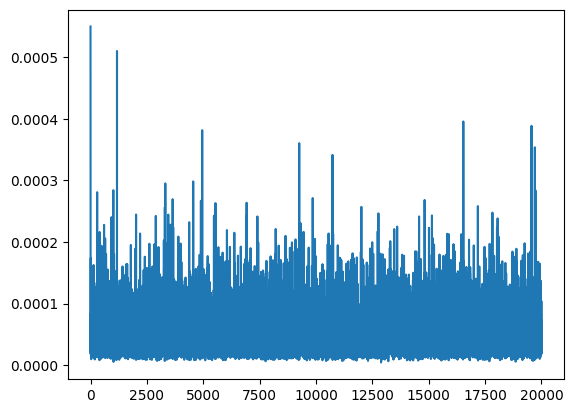

In [27]:
# Lets have a look at the probabilities
_ = plt.plot(F.softmax(data_pred[:, -1]/temp, -1).cpu().numpy().flatten())